In [1]:
pip install -U https://github.com/PythonOT/POT/archive/master.zip # with --user for user install (no root)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     \ 2.7 MB 2.5 MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for POT: filename=POT-0.8.3.dev0-cp37-cp37m-linux_x86_64.whl size=485961 sha256=ee1e3ef016b3ae6c1b20ce0993708168a3ba0357006f25d3fca41da620d06faa
  Stored in directory: /tmp/pip-ephem-wheel-cache-hg1tasjx/wheels/b3/2e/1b/18ac53d1fbe37b7553ee8adb7975c45fde93c98184ac691bc6
Successfully built POT


* $$W_2(P,Q)^2=\|\mu_x-\mu_y\|^2+ trace(Σ_x+Σ_y-2(Σ_xΣ_y)^{1/2})$$
* $$W=Σ_x^{-1/2}(Σ_x^{1/2}Σ_yΣ_x^{1/2})^{1/2}Σ_x^{-1/2}$$
* $$Y = \mu_y +W(X-\mu_x)$$

In [2]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch 
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import imageio
import os

In [3]:
import ot
import ot.plot

In [4]:
import brenier
import utils

In [5]:
device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'

* $$ G\sim \mathcal N(mean,diag(std)) $$

The ground truth W_dist is 24.80929946899414


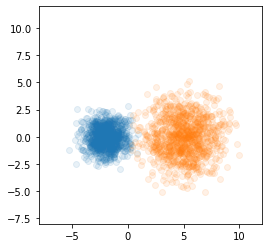

In [6]:
G1 = utils.Gaussian_distribution(np.array([-2,0]),1, 2)
G2 = utils.Gaussian_distribution(np.array([5,0]),3, 2)


source_train = G1.generate_gaussian()
target_train = G2.generate_gaussian()

Train_loader_gaussian = torch.utils.data.DataLoader(source_train,batch_size=len(source_train))

plt.figure(figsize=[4,4])
plt.scatter(source_train[:,0],source_train[:,1],alpha=0.1)
plt.scatter(target_train[:,0],target_train[:,1],alpha=0.1)
plt.xlim(-8,12)
plt.ylim(-8,12)

GT_wdist = brenier.get_wdist(torch.tensor(source_train),torch.tensor(target_train))
print(f"The ground truth W_dist is {GT_wdist}")

In [7]:
lse1 = brenier.LSE(2,500)
model_lse = brenier.c_transform(torch.tensor(target_train).float().to(device),lse1)
optimizer = torch.optim.Adam(model_lse.parameters(),0.004,[0.9,0.9],1e-6)
brenier.LSE_train(model_lse, device, Train_loader_gaussian, optimizer, 2001)
LSE_result =model_lse.transport(torch.tensor(source_train).float().to(device)).data.cpu()

0 tensor(10.4600, device='cuda:0')
500 tensor(17.4175, device='cuda:0')
1000 tensor(22.3749, device='cuda:0')
1500 tensor(24.5977, device='cuda:0')
2000 tensor(24.7947, device='cuda:0')


In [8]:
icnn1 = brenier.ICNN(input_dim=2)
model_icnn1 = brenier.c_transform(torch.tensor(target_train).float().to(device),icnn1)
optimizer = torch.optim.Adam(model_icnn1.parameters(),0.004,[0.9,0.9],1e-6)
brenier.ICNN_train(model_icnn1, device, Train_loader_gaussian, optimizer, 5001)
ICNN_result =model_icnn1.transport(torch.tensor(source_train).float().to(device)).data.cpu()

0 tensor(12.5563, device='cuda:0')
100 tensor(24.7997, device='cuda:0')
200 tensor(24.8031, device='cuda:0')
300 tensor(24.8042, device='cuda:0')
400 tensor(24.8045, device='cuda:0')
500 tensor(24.8048, device='cuda:0')
600 tensor(24.8057, device='cuda:0')
700 tensor(24.8058, device='cuda:0')
800 tensor(24.8051, device='cuda:0')
900 tensor(24.8056, device='cuda:0')
1000 tensor(24.8057, device='cuda:0')
1100 tensor(24.8058, device='cuda:0')
1200 tensor(24.8063, device='cuda:0')
1300 tensor(24.8055, device='cuda:0')
1400 tensor(24.8062, device='cuda:0')
1500 tensor(24.8060, device='cuda:0')
1600 tensor(24.8065, device='cuda:0')
1700 tensor(24.8066, device='cuda:0')
1800 tensor(24.8060, device='cuda:0')
1900 tensor(24.8062, device='cuda:0')
2000 tensor(24.8067, device='cuda:0')
2100 tensor(24.8063, device='cuda:0')
2200 tensor(24.8066, device='cuda:0')
2300 tensor(24.8069, device='cuda:0')
2400 tensor(24.8069, device='cuda:0')
2500 tensor(24.8061, device='cuda:0')
2600 tensor(24.8062, dev

In [9]:
icnn2 = brenier.ICNN(2)
model_icnn2 = brenier.c_transform(torch.tensor(target_train).float().to(device),icnn2)
optimizer2 = torch.optim.Adam(model_icnn2.parameters(),0.004,[0.9,0.9],1e-6)

brenier.mix_train(model_icnn2,device, Train_loader_gaussian, optimizer2, 500,alpha=0.1)
mix_result =model_icnn2.transport(torch.tensor(source_train).float().to(device)).data.cpu()

0 tensor(30.3720, device='cuda:0') tensor(12.5857, device='cuda:0')
100 tensor(0.0751, device='cuda:0') tensor(24.7995, device='cuda:0')
200 tensor(0.0626, device='cuda:0') tensor(24.8039, device='cuda:0')
300 tensor(0.0610, device='cuda:0') tensor(24.8046, device='cuda:0')
400 tensor(0.0574, device='cuda:0') tensor(24.8051, device='cuda:0')


In [10]:
mlp1 = brenier.MLP(2)
optimizer = torch.optim.Adam(mlp1.parameters(),0.004,[0.9,0.9],1e-6)
brenier.MLP_train(mlp1, device, Train_loader_gaussian, torch.tensor(target_train).float().to(device) ,optimizer, 301)
MLP_result =mlp1(torch.tensor(source_train).float().to(device)).data.cpu()

In [11]:
def plot_contour(ax,c_transform_model,x_lim,y_lim,source,target,result,title):

  xlist = np.linspace(x_lim[0], x_lim[1], 100)
  ylist = np.linspace(y_lim[0], y_lim[1], 100)
  X, Y = np.meshgrid(xlist, ylist)
  cord = np.concatenate([X.reshape(-1,1),Y.reshape(-1,1)],axis = 1)

  Z = c_transform_model.phi_Brenier(torch.tensor(cord).float().to(device)).data.cpu().reshape(X.shape)  
  cp = ax.contourf(X, Y, Z, cmap='coolwarm')

  C = ax.contour(X, Y, Z, colors='black', linewidth=.5)
  ax.clabel(C, inline=True, fontsize=10)
  
  #fig.colorbar(cp) # Add a colorbar to a plot

  ax.set_title(title)

  ax.scatter(source[:,0],source[:,1],alpha = 0.25)
  ax.scatter(target[:,0],target[:,1],alpha = 0.25)
  ax.scatter(result[:,0],result[:,1],alpha = 0.25)

  return ax

In [12]:
assert G1.dim == G2.dim
W = np.diag(np.ones(G1.dim)*G2.std/G1.std)**0.5
GT_result = (source_train-G1.mean)@W + G2.mean

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: The following kwargs were not used by contour: 'linewidth'
  # This is added back by InteractiveShellApp.init_path()


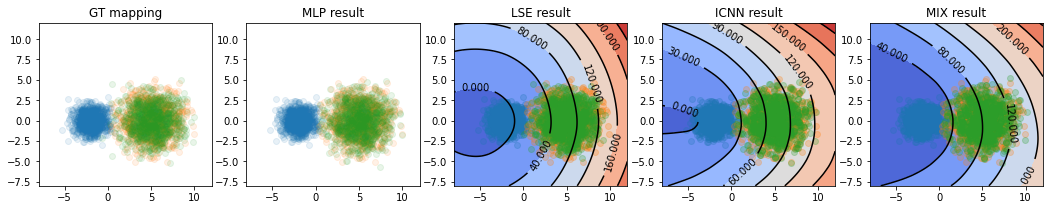

In [13]:
fig,ax = plt.subplots(1,5,figsize = [18,3])


ax[0].set_xlim(-8,12)
ax[0].set_ylim(-8,12)
ax[0].set_title("GT mapping")
ax[0].scatter(source_train[:,0],source_train[:,1],alpha=0.1)
ax[0].scatter(target_train[:,0],target_train[:,1],alpha=0.1)
ax[0].scatter(GT_result[:,0],GT_result[:,1],alpha=0.1)

ax[1].set_xlim(-8,12)
ax[1].set_ylim(-8,12)
ax[1].set_title("MLP result")
ax[1].scatter(source_train[:,0],source_train[:,1],alpha=0.1)
ax[1].scatter(target_train[:,0],target_train[:,1],alpha=0.1)
ax[1].scatter(MLP_result[:,0],MLP_result[:,1],alpha=0.1)


ax[2]=plot_contour(ax[2],model_lse,[-8,12],[-8,12],source_train,target_train,LSE_result,'LSE result')

ax[3]=plot_contour(ax[3],model_icnn1,[-8,12],[-8,12],source_train,target_train,ICNN_result,'ICNN result')

ax[4]=plot_contour(ax[4],model_icnn2,[-8,12],[-8,12],source_train,target_train,mix_result,'MIX result')

plt.savefig('Gaussian_results.pdf',bbox_inches="tight")


In [14]:
mlp_mse = ((MLP_result-GT_result)**2).mean()
lse_mse = ((LSE_result-GT_result)**2).mean()
icnn_mse = ((ICNN_result-GT_result)**2).mean()
mix_mse = ((mix_result-GT_result)**2).mean()

print("mlp_mse",mlp_mse)
print("lse_mse",lse_mse)
print("icnn_mse",icnn_mse)
print("mix_mse",mix_mse)

mlp_mse tensor(0.0181, dtype=torch.float64)
lse_mse tensor(0.0180, dtype=torch.float64)
icnn_mse tensor(0.0409, dtype=torch.float64)
mix_mse tensor(0.0347, dtype=torch.float64)


In [ ]:
n_sample = [20,50,100,200,500,1000]
dim = [1,2,5,10,20,50,100,200,500]

len_n = len(n_sample)
len_d = len(dim)

In [ ]:
icnn_mse = np.zeros([len_d,len_n])
mlp_mse = np.zeros([len_d,len_n])
lse_mse = np.zeros([len_d,len_n])
mix_mse = np.zeros([len_d,len_n])

In [ ]:
it = 1

for i in range(len_d):
  for j in range(len_n):
    for _ in range(it):
      # generate Gaussian
      G1 = utils.Gaussian_distribution(np.zeros(dim[i]),1, dim[i])
      G2 = utils.Gaussian_distribution(np.ones(dim[i]),3, dim[i])

      source_train = G1.generate_gaussian(n_sample=n_sample[j])
      target_train = G2.generate_gaussian(n_sample=n_sample[j])

      assert G1.dim == G2.dim
      W = np.diag(np.ones(G1.dim)*G2.std/G1.std)**0.5
      GT_result = (source_train-G1.mean)@W + G2.mean

      Train_loader_gaussian = torch.utils.data.DataLoader(source_train,batch_size=len(source_train))

      # ICNN train
      icnn1 = brenier.ICNN(dim[i])
      model_icnn = brenier.c_transform(torch.tensor(target_train).float().to(device),icnn1)
      optimizer = torch.optim.Adam(model_icnn.parameters(),0.004,[0.9,0.9],1e-6)
      brenier.ICNN_train(model_icnn, device, Train_loader_gaussian, optimizer, 5001,print_bool=False)
      ICNN_result =model_icnn.transport(torch.tensor(source_train).float().to(device)).data.cpu()
      icnn_mse[i,j] += ((ICNN_result-GT_result)**2).mean()/it

      # MLP train
      mlp1 = brenier.MLP(dim[i])
      optimizer = torch.optim.Adam(mlp1.parameters(),0.004,[0.9,0.9],1e-6)
      brenier.MLP_train(mlp1, device,Train_loader_gaussian, torch.tensor(target_train).float().to(device) ,optimizer, 501,print_bool=False)
      MLP_result =mlp1(torch.tensor(source_train).float().to(device)).data.cpu()
      mlp_mse[i,j] += ((MLP_result-GT_result)**2).mean()/it

      # LSE train

      lse1 = brenier.LSE(dim[i],100)
      model_lse = brenier.c_transform(torch.tensor(target_train).float().to(device),lse1).to(device)
      optimizer = torch.optim.Adam(model_lse.parameters(),0.004,[0.9,0.9],2e-6)
      brenier.LSE_train(model_lse, device, Train_loader_gaussian, optimizer, 501,print_bool=False)
      LSE_result =model_lse.transport(torch.tensor(source_train).float().to(device)).data.cpu()
      lse_mse[i,j] += ((LSE_result-GT_result)**2).mean()/it


    print(f"(dim,n_sample)=({dim[i]},{n_sample[j]}),icnn_mse={'%6.3f'%icnn_mse[i,j]},mlp_mse={'%6.3f'%mlp_mse[i,j]},lse_mse={'%6.3f'%lse_mse[i,j]}")

(dim,n_sample)=(1,20),icnn_mse= 1.133,mlp_mse= 1.050,lse_mse= 0.970
(dim,n_sample)=(1,50),icnn_mse= 0.650,mlp_mse= 0.647,lse_mse= 0.529
(dim,n_sample)=(1,100),icnn_mse= 0.287,mlp_mse= 0.253,lse_mse= 0.219
(dim,n_sample)=(1,200),icnn_mse= 0.036,mlp_mse= 0.034,lse_mse= 0.019
(dim,n_sample)=(1,500),icnn_mse= 0.067,mlp_mse= 0.058,lse_mse= 0.060
(dim,n_sample)=(1,1000),icnn_mse= 0.012,mlp_mse= 0.013,lse_mse= 0.009
(dim,n_sample)=(2,20),icnn_mse= 0.432,mlp_mse= 0.800,lse_mse= 0.439
(dim,n_sample)=(2,50),icnn_mse= 0.575,mlp_mse= 0.653,lse_mse= 0.297
(dim,n_sample)=(2,100),icnn_mse= 0.197,mlp_mse= 0.295,lse_mse= 0.144
(dim,n_sample)=(2,200),icnn_mse= 0.153,mlp_mse= 0.192,lse_mse= 0.069
(dim,n_sample)=(2,500),icnn_mse= 0.056,mlp_mse= 0.059,lse_mse= 0.028
(dim,n_sample)=(2,1000),icnn_mse= 0.025,mlp_mse= 0.020,lse_mse= 0.015
(dim,n_sample)=(5,20),icnn_mse= 2.238,mlp_mse= 2.511,lse_mse= 1.086
(dim,n_sample)=(5,50),icnn_mse= 0.816,mlp_mse= 1.534,lse_mse= 0.302
(dim,n_sample)=(5,100),icnn_mse= 0.525

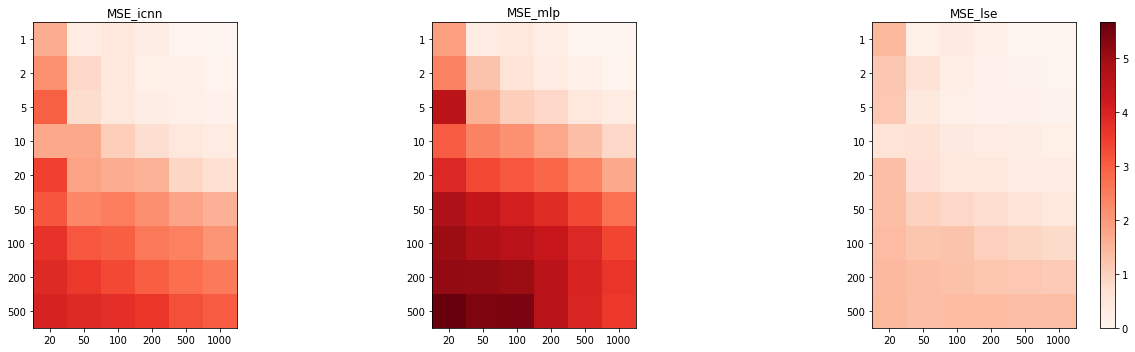

In [ ]:
fig, ax = plt.subplots(1,3,figsize=[18,5])
vmax = max(icnn_mse.max(),mlp_mse.max(),lse_mse.max())
# icnn result
img0 = ax[0].imshow(icnn_mse,cmap='Reds',vmax= vmax,vmin=0)
ax[0].set_xticks(np.arange(len(n_sample)))
ax[0].set_xticklabels(n_sample)
ax[0].set_yticks(np.arange(len(dim)))
ax[0].set_yticklabels(dim)
ax[0].set_title("MSE_icnn")
# mpl result
img1 = ax[1].imshow(mlp_mse,cmap='Reds',vmax= vmax,vmin=0)
ax[1].set_xticks(np.arange(len(n_sample)))
ax[1].set_xticklabels(n_sample)
ax[1].set_yticks(np.arange(len(dim)))
ax[1].set_yticklabels(dim)
ax[1].set_title("MSE_mlp")
# lse result
img2 = ax[2].imshow(lse_mse,cmap='Reds',vmax= vmax,vmin=0)
ax[2].set_xticks(np.arange(len(n_sample)))
ax[2].set_xticklabels(n_sample)
ax[2].set_yticks(np.arange(len(dim)))
ax[2].set_yticklabels(dim)
ax[2].set_title("MSE_lse")
fig.tight_layout()

fig.colorbar(img1)

plt.savefig('MSE_results.pdf',bbox_inches="tight")

In [ ]:
mlp_mse = np.round(mlp_mse,3)
np.savetxt("mlp.csv", mlp_mse, delimiter=",")

lse_mse=np.round(lse_mse,3)
np.savetxt("lse.csv", lse_mse, delimiter=",")

icnn_mse=np.round(icnn_mse,3)
np.savetxt("icnn.csv", icnn_mse, delimiter=",")

two moon

In [15]:
moon = utils.TwoMoon()
source_train = moon.source_train
target_train = moon.target_train
source_test  = moon.source_test
target_test  = moon.target_test

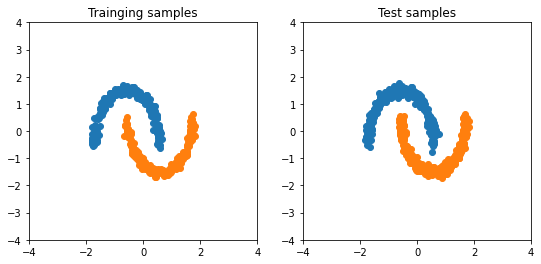

In [16]:
fig,ax = plt.subplots(1,2,figsize = [9,4])

ax[0].set_xlim(-4,4)
ax[0].set_ylim(-4,4)
ax[0].set_title("Trainging samples")
ax[0].scatter(source_train[:,0],source_train[:,1])
ax[0].scatter(target_train[:,0],target_train[:,1])

ax[1].set_xlim(-4,4)
ax[1].set_ylim(-4,4)
ax[1].set_title("Test samples")
ax[1].scatter(source_test[:,0],source_test[:,1])
ax[1].scatter(target_test[:,0],target_test[:,1])

In [17]:
Train_loader_moon = torch.utils.data.DataLoader(source_train,batch_size=len(source_train))

lse1 = brenier.LSE(2,500,alpha=0.5)
model_lse = brenier.c_transform(torch.tensor(target_train).float().to(device),lse1)

optimizer = torch.optim.Adam(model_lse.parameters(),0.004,[0.9,0.9],1e-6)
brenier.LSE_train(model_lse, device, Train_loader_moon, optimizer, 2001)
LSE_result =model_lse.transport(torch.tensor(source_train).float().to(device)).data.cpu()

0 tensor(0.3838, device='cuda:0')
500 tensor(1.8911, device='cuda:0')
1000 tensor(1.9007, device='cuda:0')
1500 tensor(1.9034, device='cuda:0')
2000 tensor(1.9040, device='cuda:0')


In [18]:
Train_loader_moon = torch.utils.data.DataLoader(source_train,batch_size=len(source_train))

icnn1 = brenier.ICNN(2)
model_icnn1 = brenier.c_transform(torch.tensor(target_train).float().to(device),icnn1)
optimizer = torch.optim.Adam(model_icnn1.parameters(),0.004,[0.9,0.9],1e-6)
brenier.ICNN_train(model_icnn1, device, Train_loader_moon, optimizer, 301)
ICNN_result =model_icnn1.transport(torch.tensor(source_train).float().to(device)).data.cpu()

0 tensor(1.0465, device='cuda:0')
100 tensor(2.0058, device='cuda:0')
200 tensor(2.0077, device='cuda:0')
300 tensor(2.0078, device='cuda:0')


In [19]:
icnn2 = brenier.ICNN(2)
model_icnn2 = brenier.c_transform(torch.tensor(target_train).float().to(device),icnn2)
optimizer2 = torch.optim.Adam(model_icnn2.parameters(),0.004,[0.9,0.9],1e-6)

brenier.mix_train(model_icnn2,device, Train_loader_moon, optimizer2, 500,alpha=0.15)
mix_result =model_icnn2.transport(torch.tensor(source_train).float().to(device)).data.cpu()

0 tensor(2.0917, device='cuda:0') tensor(0.7485, device='cuda:0')
100 tensor(0.0276, device='cuda:0') tensor(2.0053, device='cuda:0')
200 tensor(0.0183, device='cuda:0') tensor(2.0070, device='cuda:0')
300 tensor(0.0164, device='cuda:0') tensor(2.0079, device='cuda:0')
400 tensor(0.0163, device='cuda:0') tensor(2.0080, device='cuda:0')


In [20]:
mlp1 = brenier.MLP(2)
optimizer = torch.optim.Adam(mlp1.parameters(),0.004,[0.9,0.9],1e-6)
brenier.MLP_train(mlp1, device, Train_loader_moon, torch.tensor(target_train).float().to(device) ,optimizer, 301)
MLP_result =mlp1(torch.tensor(source_train).float().to(device)).data.cpu()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: The following kwargs were not used by contour: 'linewidth'
  # This is added back by InteractiveShellApp.init_path()


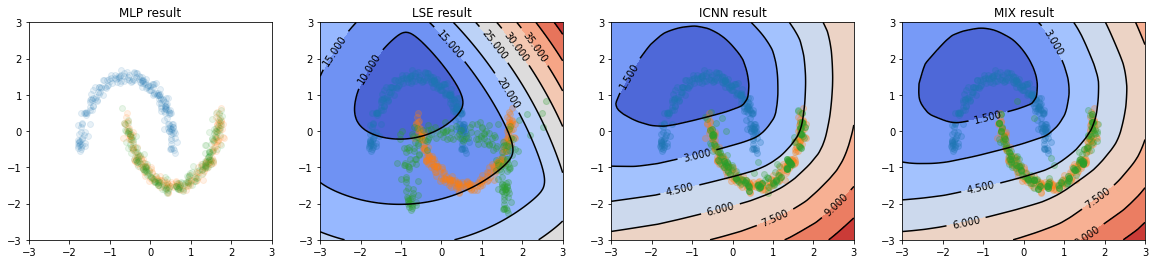

In [24]:
fig,ax = plt.subplots(1,4,figsize = [20,4])


ax[0].set_xlim(-3,3)
ax[0].set_ylim(-3,3)
ax[0].set_title("MLP result")
ax[0].scatter(source_train[:,0],source_train[:,1],alpha=0.1)
ax[0].scatter(target_train[:,0],target_train[:,1],alpha=0.1)
ax[0].scatter(MLP_result[:,0],MLP_result[:,1],alpha=0.1)


ax[1]=plot_contour(ax[1],model_lse,[-3,3],[-3,3],source_train,target_train,LSE_result,'LSE result')

ax[2]=plot_contour(ax[2],model_icnn1,[-3,3],[-3,3],source_train,target_train,ICNN_result,'ICNN result')

ax[3]=plot_contour(ax[3],model_icnn2,[-3,3],[-3,3],source_train,target_train,mix_result,'MIX result')

plt.savefig('TwoMoon_result.pdf',bbox_inches="tight")

lse Test

In [25]:
alpha_value = np.linspace(-1, 1, 100)

for i,temp_alpha in enumerate(alpha_value):

  
  temp_lse = brenier.LSE(2,500,alpha=temp_alpha)
  temp_model_lse = brenier.c_transform(torch.tensor(target_train).float().to(device),temp_lse)

  optimizer = torch.optim.Adam(temp_model_lse.parameters(),0.004,[0.9,0.9],1e-6)
  brenier.LSE_train(temp_model_lse, device, Train_loader_moon, optimizer, 2001,print_bool = False)
  LSE_result =temp_model_lse.transport(torch.tensor(source_train).float().to(device)).data.cpu()

  fig,ax = plt.subplots(1,1,figsize = [5,4])
  ax = plot_contour(ax,temp_model_lse,[-3,3],[-3,3],source_train,target_train,LSE_result,f'alpha is {temp_alpha.round(3)}')
  plt.savefig(f"{i}.png")
  plt.close()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: The following kwargs were not used by contour: 'linewidth'
  # This is added back by InteractiveShellApp.init_path()


In [26]:
with imageio.get_writer("sample_data/moon.gif", mode="I") as writer:
  for i,temp_alpha in enumerate(alpha_value):
            image = imageio.imread(f"{i}.png")
            writer.append_data(image)
            os.remove(f"{i}.png")